In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [28]:
# Load the dataset
DATA_PATH = '../data-preprocessing/VinhLong_data.csv'
data = pd.read_csv(DATA_PATH)
data = data[data['Nhiệt độ'] <= 60]

In [29]:
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')
data['Giờ'] = pd.to_datetime(data['Giờ'], format='%H:%M').dt.time
data['Datetime'] = pd.to_datetime(data['Ngày'].astype(str) + ' ' + data['Giờ'].astype(str))
data.set_index('Datetime', inplace=True)
data.drop(['Ngày', 'Giờ'], axis=1, inplace=True)
data.head()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
Datetime,,,,,
2014-01-01 01:00:00,22.2,89,1013.7,1.3,225
2014-01-01 02:00:00,21.8,90,1012.9,1,270
2014-01-01 03:00:00,22.8,80,1012.5,3.1,320
2014-01-01 04:00:00,22.7,80,1012.5,1.2,235
2014-01-01 05:00:00,22.0,84,1012.5,3.7,319


In [30]:
data.replace(['-', ''], np.nan, inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric, errors='ignore')
data.tail()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
Datetime,,,,,
2024-01-15 19:00:00,28.3,65,1011.8,2.2,154
2024-01-15 20:00:00,27.4,70,1012.1,2.1,152
2024-01-15 21:00:00,27.0,72,1012.5,0.2,149
2024-01-15 22:00:00,26.5,75,1012.2,1.3,153
2024-02-21 07:00:00,24.4,97,1012.6,1.4,142


In [31]:
print(data.isna().sum())

Nhiệt độ    0
Độ ẩm       0
Khí áp      0
T.độ gió    0
H. gió      0
dtype: int64


In [32]:
hourly_data = data.resample('H').mean()
hourly_data.replace(['-', ''], np.nan, inplace=True)
hourly_data.dropna(inplace=True)
hourly_data = hourly_data.apply(pd.to_numeric, errors='ignore')
hourly_data.tail()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
Datetime,,,,,
2024-01-15 19:00:00,28.3,65.0,1011.8,2.2,154.0
2024-01-15 20:00:00,27.4,70.0,1012.1,2.1,152.0
2024-01-15 21:00:00,27.0,72.0,1012.5,0.2,149.0
2024-01-15 22:00:00,26.5,75.0,1012.2,1.3,153.0
2024-02-21 07:00:00,24.4,97.0,1012.6,1.4,142.0


In [33]:
hourly_data.reset_index(drop=True, inplace=True)

In [34]:
hourly_data.head()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
0,22.2,89.0,1013.7,1.3,225.0
1,21.8,90.0,1012.9,1.0,270.0
2,22.8,80.0,1012.5,3.1,320.0
3,22.7,80.0,1012.5,1.2,235.0
4,22.0,84.0,1012.5,3.7,319.0


In [35]:
print(hourly_data.isna().sum())

Nhiệt độ    0
Độ ẩm       0
Khí áp      0
T.độ gió    0
H. gió      0
dtype: int64


In [36]:
# data_length = len(hourly_data)

# train_idx = int(data_length * 0.80)
# test_idx = int(data_length * 0.20)

# train = hourly_data[:train_idx]
# test = hourly_data[train_idx:]

# print(f"Train Shape: {train.shape}")
# print(f"Test Shape: {test.shape}")

In [37]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [38]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [39]:
# testX = test['Nhiệt độ']
# testy = test.drop(columns=['Nhiệt độ'])
# trainX = train['Nhiệt độ']
# trainy = train.drop(columns=['Nhiệt độ'])

In [40]:
def create_features(data, n_lags=3):
    df = data.copy()
    for n in range(1, n_lags + 1):
        df[f'lag_{n}'] = df['Nhiệt độ'].shift(n)
    # df['rolling_mean_3'] = df['Nhiệt độ'].rolling(window=3).mean()
    # target
    df['target_temp'] = df['Nhiệt độ'].shift(-1)
    df['target_humidity'] = df['Độ ẩm'].shift(-1)
    df['target_baro'] = df['Khí áp'].shift(-1)
    df['target_windspeed'] = df['T.độ gió'].shift(-1)
    df['target_winddirec'] = df['H. gió'].shift(-1)
    df.dropna(inplace=True)
    return df

# Apply feature engineering
hourly_data = create_features(hourly_data, n_lags=3)


In [41]:
from sklearn.preprocessing import StandardScaler


In [42]:
from sklearn.model_selection import GridSearchCV

def xgboost_grid_search(trainX, trainy):
    model = XGBRegressor(objective='reg:squarederror')
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(trainX, trainy)
    print("Best parameters found: ", grid_search.best_params_)
    return grid_search.best_estimator_

In [50]:
def xgboost_forecast(train, testX, scaler):
    train = np.asarray(train)
    trainX, trainy = train[:, :-5], train[:, -5:]
    model = MultiOutputRegressor(xgboost_grid_search(trainX, trainy))
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    yhat_full = np.zeros((1, scaler.scale_.shape[0]))
    yhat_full[0, -5:] = yhat  
    yhat = scaler.inverse_transform(yhat_full)[:, -5:]
    return yhat[0]


In [44]:
def rolling_forecast(data, window_size, n_test, scaler):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        # Define the rolling window for training
        rolling_train = history[-window_size:]
        testX, testy = test[i, :-5], test[i, -5:]
        yhat = xgboost_forecast(rolling_train, testX, scaler)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy[0], yhat[0]))
    predictions = np.array(predictions)
    test = scaler.inverse_transform(test)[:, -5:]  # Inverse transform the test data
    error = np.sqrt(mean_squared_error(test, predictions, multioutput='raw_values'))
    return error, test, predictions

In [45]:
hourly_data.head()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió,lag_1,lag_2,lag_3,target_temp,target_humidity,target_baro,target_windspeed,target_winddirec
3,22.7,80.0,1012.5,1.2,235.0,22.8,21.8,22.2,22.0,84.0,1012.5,3.7,319.0
4,22.0,84.0,1012.5,3.7,319.0,22.7,22.8,21.8,21.6,85.0,1013.2,2.2,321.0
5,21.6,85.0,1013.2,2.2,321.0,22.0,22.7,22.8,21.5,83.0,1014.0,1.7,283.0
6,21.5,83.0,1014.0,1.7,283.0,21.6,22.0,22.7,21.8,83.0,1014.7,2.7,303.0
7,21.8,83.0,1014.7,2.7,303.0,21.5,21.6,22.0,22.7,80.0,1014.9,2.1,299.0


In [46]:
print(hourly_data.isna().sum())

Nhiệt độ            0
Độ ẩm               0
Khí áp              0
T.độ gió            0
H. gió              0
lag_1               0
lag_2               0
lag_3               0
target_temp         0
target_humidity     0
target_baro         0
target_windspeed    0
target_winddirec    0
dtype: int64


In [47]:
from sklearn.metrics import mean_squared_error

window_size = 100

scaler = StandardScaler()
hourly_data_scaled = scaler.fit_transform(hourly_data)

# Evaluate the model
rmse, y, yhat = rolling_forecast(hourly_data_scaled, window_size, 12, scaler)

# Print RMSE for each target
targets = ['Temperature', 'Humidity', 'Pressure', 'Wind Speed', 'Wind Direction']
for i, target in enumerate(targets):
    print(f'RMSE for {target}: {rmse[i]:.3f}')

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=1.4, predicted=27.3
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=1.2, predicted=30.7
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=0.2, predicted=30.0
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=-0.2, predicted=28.3
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=-0.2, predicted=27.8
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=1.2, predicted=27.6
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=0.9, predicted=29.7
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
>expected=0.1, predicted=29.2
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators'

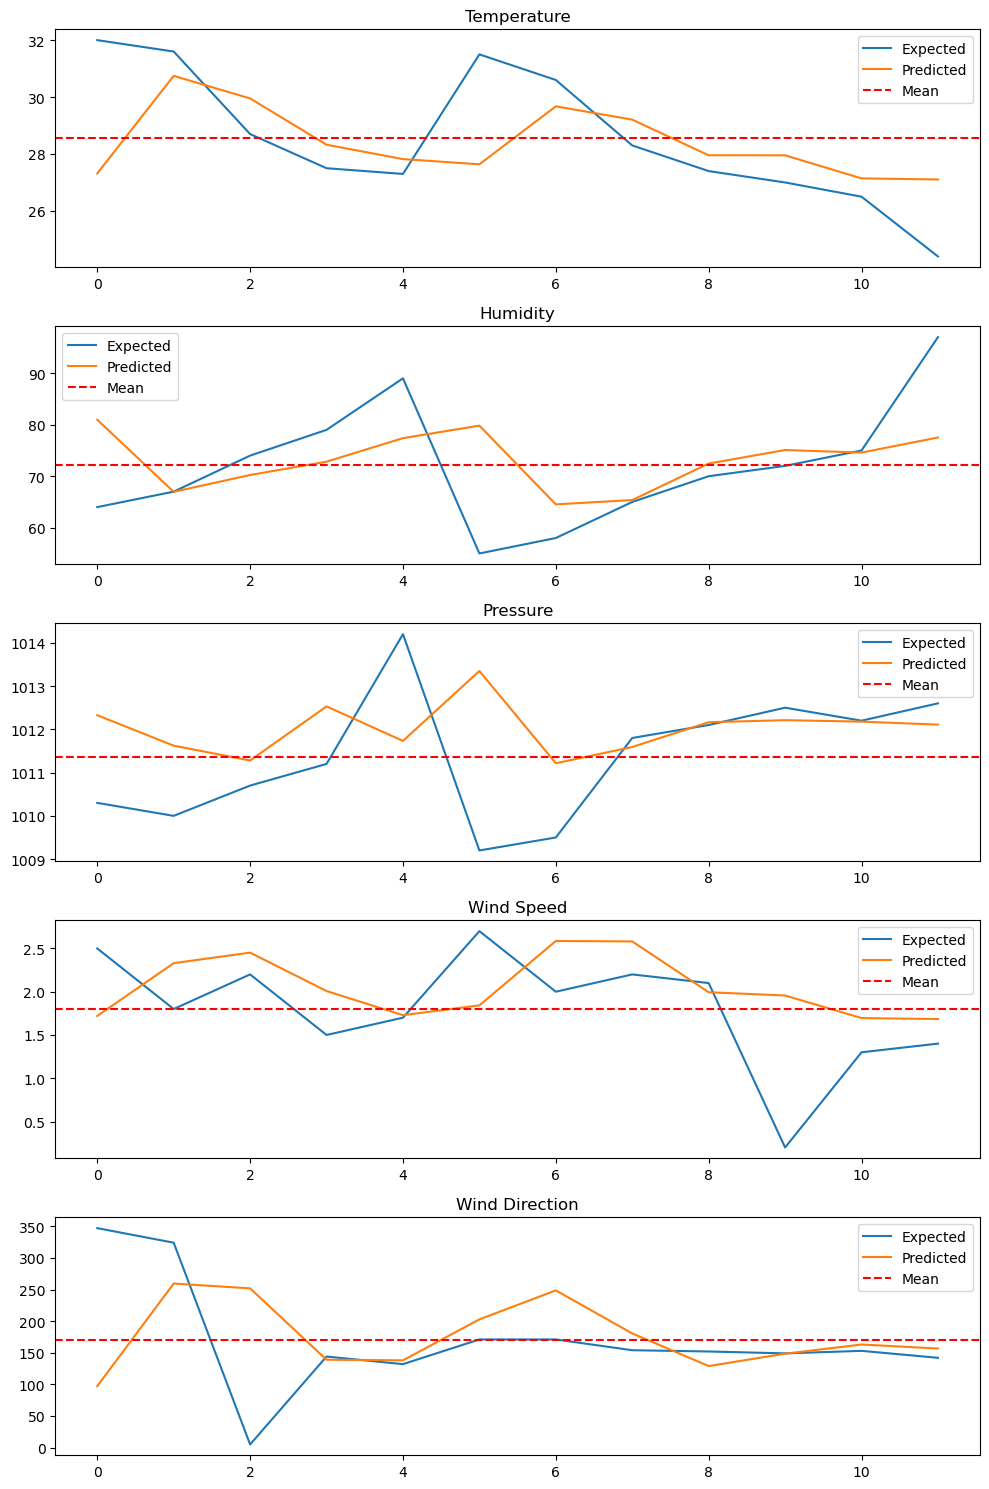

In [49]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))
targets = ['Temperature', 'Humidity', 'Pressure', 'Wind Speed', 'Wind Direction']
for i, ax in enumerate(axes):
    ax.plot(y[:, i], label='Expected')
    ax.plot(yhat[:, i], label='Predicted')
    mean_value = np.mean(y[:, i])
    ax.axhline(y=mean_value, color='r', linestyle='--', label='Mean')
    ax.set_title(targets[i])
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# # Function to perform walk-forward validation
# def walk_forward_validation(data, n_test):
#     predictions = list()
#     train, test = train_test_split(data.values, n_test)
#     history = [x for x in train]
#     for i in range(len(test)):
#         testX, testy = test[i, :-1], test[i, -1]
#         yhat = xgboost_forecast(history, testX)
#         predictions.append(yhat)
#         history.append(test[i])
#         print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
#     error = mean_absolute_error(test[:, -1], predictions)
#     return error, test[:, -1], predictions

# # Evaluate the model
# mae, y, yhat = walk_forward_validation(hourly_data, 12)
# print('MAE: %.3f' % mae)

# # Plot expected vs predicted values
# plt.plot(y, label='Expected')
# plt.plot(yhat, label='Predicted')
# plt.legend()
# plt.show()
